In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

In [2]:
pays_ocde = {"Germany" :'DEU',"Australia" :'AUS',"Austria":'AUT',"Belgium":'BEL',"Canada":'CAN',"Denmark":'DNK',"Spain":'ESP',"Finland":'FIN',"France":'FRA',"Greece":'GRC',"Ireland":'IRL',"Italy":'ITA',
             "Japan":'JPN',"Luxembourg":'LUX',"Norway":'NOR',"New-Zealand":'NZL',"Netherlands":'NLD',"Portugal":'PRT',"United Kingdom":'GBR',"Sweden":'SWE',"Switzerland":'CHE',"Turkey":'TUR',"United-States":'USA'}

variables = ['Actifs', 'Chomage', 'Conso', 'Emplois', 'Exports', 'Formation', 'PIB']


In [3]:
#On importe les données
data = pd.read_csv(r'C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\STAT APP\Stat-app-Trumpnomics\ocde_df.csv',header = [0,1])
data.head()

Pays  Australia                                                  \
    Variables     Actifs   Chomage    Conso    Emplois Exports Formation   
0        date        NaN       NaN      NaN        NaN     NaN       NaN   
1  1990-01-01  63.559455  6.230017  108.373  59.599611  26.942    41.272   
2  1990-04-01  63.786530  6.464528  108.965  59.662825  26.986    39.657   
3  1990-07-01  63.928685  7.225374  109.106  59.309783  28.052    39.505   
4  1990-10-01  63.697744  7.867509  108.421  58.686347  28.496    38.098   

                                        ... United Kingdom United-States  \
       PIB income p0p50 income p90p100  ... income p90p100        Actifs   
0      NaN          NaN            NaN  ...            NaN           NaN   
1  206.890          NaN            NaN  ...            NaN     66.733333   
2  207.173          NaN            NaN  ...            NaN     66.533333   
3  205.931          NaN            NaN  ...            NaN     66.466667   
4  207.139          NaN            NaN  ...            NaN     66.400000   

                                                                            \
    Chomage     Conso    Emplois  Exports Formation       PIB income p0p50   
0       NaN       NaN        NaN      NaN       NaN       NaN          NaN   
1  5.300000  5998.058  63.200000  682.300  1695.374  9358.289          NaN   
2  5.333333  6016.329  63.000000  690.785  1668.437  9392.251          NaN   
3  5.700000  6040.163  62.666667  696.014  1659.143  9398.499          NaN   
4  6.133333  5994.212  62.333333  702.143  1628.395  9312.937          NaN   

                  
  income p90p100  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 208 columns]

In [5]:
#On supprime les inégalités qui ne nous intéressent pas pour l'instant.
for i in pays_ocde.keys() :
    data= data.drop([(i,'income p0p50'),(i,'income p90p100')], axis=1)

In [8]:
#On trie les données pour améliorer les performances et éviter les warnings:
data = data.sort_index(axis=1)

In [10]:
#on créé le dataframe qui nous intéresse qui est de la forme : pays en colonnes, 
#année + variable en ligne (une ligne est donc la valeur d'une variable, pour une 
#année donnée dans chaque pays)
df_ct = pd.DataFrame()
for i in variables :
    interm = data.xs(str(i), axis=1, level=1, drop_level=True)   #On prend uniquement les colonnes qui se rapporte à une variable avec .xs
    interm = interm.drop(0, axis=0)                                #On enlève la ligne d'indice 0 qui est vide (seulement des nan)
    interm['Variables'] = str(i)                                    #on rajoute une colonne "variables" qui nous servira plus tard pour construire le problème d'optimisation
    df_ct = pd.concat([df_ct, interm], axis=0)                      #On concatène le df ainsi créé avec les autres
df_ct

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Greece,Ireland,...,New-Zealand,Norway,Portugal,Spain,Sweden,Switzerland,Turkey,United Kingdom,United-States,Variables
1,63.559455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.733333,Actifs
2,63.786530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.533333,Actifs
3,63.928685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.466667,Actifs
4,63.697744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.400000,Actifs
5,63.399539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.233333,Actifs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,486.394000,93.018269,110.154,519.63425,528.7403,51.057,576.639,806.32566,45.273795,83.667568,...,64.664,894.627,50.018848,295.252,1251.048,180.996264,426.215,538.222,18813.923000,PIB
117,488.812000,93.762671,110.329,520.09275,532.8994,51.210,579.566,811.26217,45.689703,83.262105,...,65.226,894.077,50.352360,296.794,1256.126,181.303805,433.392,541.195,18950.347000,PIB
118,491.985000,93.464607,110.673,525.65325,538.4743,51.685,581.218,807.17671,45.924068,87.379369,...,65.448,895.504,50.625731,297.916,1257.054,181.975340,442.359,541.944,19020.599000,PIB
119,494.974000,93.753514,111.234,528.02975,541.2217,51.578,582.073,809.67340,45.610855,86.606728,...,65.915,895.051,50.826445,298.970,1255.231,182.961180,444.139,544.639,19141.744000,PIB


In [13]:
# Modélisation avec la moyenne sur la période pré-intervention

np.set_printoptions(suppress=True) # Pcq relou les notations avec exponentielles

X1 = df_ct.dropna()[['United-States','Variables']]
X1 = X1.drop(list(d for d in range (109,120)))
X1 = X1.groupby('Variables').mean()
X1 = X1.values

X0 = df_ct.dropna().drop('United-States', axis=1)
X0 = X0.drop(list(d for d in range (109,120)))
X0 = X0.groupby('Variables').mean()
X0 = X0.values
X0, X1

(array([[    65.10403576,     60.70123904,     53.45155577,
             66.3875    ,     62.39422731,     59.49443881,
             56.22587821,     60.17781084,     52.40733498,
             62.36045486,     48.84908718,     59.70602941,
             58.76027517,     64.65634011,     68.4375    ,
             68.86289958,     59.79067989,     59.18579554,
             64.5058707 ,     67.76732801,     49.82117586,
             62.61216827],
        [     5.48470094,      5.19941243,      7.8911374 ,
              7.165625  ,      6.83125902,      8.24770699,
              9.45103483,      5.49967799,     20.99020035,
             12.03899169,     10.40302112,      3.97708333,
              5.5045557 ,      5.89702044,      5.609375  ,
              3.59496082,     12.55009511,     21.34393378,
              7.71029809,      4.59764296,      9.7915918 ,
              6.61749681],
        [   202.11665753,     42.45803959,     48.45836986,
            229.31094178,    210.33683151,    

In [14]:
# On construit et on "résout" le problème cvxpy
x = cvx.Variable((22,1),nonneg=True)                #On définit un vecteur de variables cvxpy
cost = cvx.norm(X1 - X0@x, p=2)                     #on définit la fonction de cout : norme des résidus
constraints = [x>=0, cvx.sum(x)==1]                     #La contrainte
prob = cvx.Problem(cvx.Minimize(cost), constraints)  #On définit le problème
prob.solve()                                        #On le résout


1944.8136141078194

In [15]:
#Print result.
print("\nThe optimal value is", prob.value)
print("The optimal x is")
print(x.value)
print("The norm of the residual is ", cvx.norm(X0@x - X1, p=2).value)



The optimal value is 1944.8136141078194
The optimal x is
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00000001]
 [0.        ]
 [0.00000001]
 [0.11980174]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00000001]
 [0.00000001]
 [0.        ]
 [0.        ]
 [0.00000001]
 [0.88019819]]
The norm of the residual is  1944.8136176479065


In [17]:
# Visualisation 

# Voici la table des coefficients attribués à chaque pays
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Parce que là aussi les notations expo rendent les résultats illisibles

country_list = df_ct.dropna().drop(['United-States', 'Variables'], axis=1)
coeff = pd.DataFrame(x.value, index=country_list.columns)
coeff

,0
Australia,0.000
Austria,0.000
Belgium,0.000
Canada,0.000
Denmark,0.000
Finland,0.000
France,0.000
Germany,0.000
Greece,0.000
Ireland,0.000


<ipython-input-23-f040d4332b1d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pib.dropna(inplace=True)


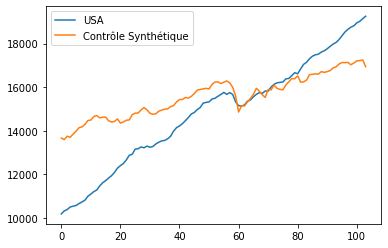

In [23]:
# Commençons par visualiser l'écart de tendance en PIB

df_pib = df_ct[df_ct["Variables"]=="PIB"]
df_pib.drop(df_pib.columns.difference(['United-States', 'United Kingdom', 'Japan']), 1, inplace=True)
df_pib.dropna(inplace=True)
df_pib = df_pib.reset_index().drop('index', 1)

sc = 0.88*df_pib['United Kingdom'] + 0.12*df_pib.Japan

df_pib['United-States'].plot(label='USA')
sc.plot(label="Contrôle Synthétique")
plt.legend()
plt.show()

In [25]:
from cif import cif
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [43]:
headers = ['PIB', 'Emplois', 'Actifs', 'Chomage', 'Conso', 'Formation', 'Exports']
ocde_df = pd.DataFrame(columns = headers.append('Pays'))

liste_var = ['NAEXKP01', 'LREMTTTT', 'LRACTTTT', 'LRUNTTTT', 'NAEXKP02', 'NAEXKP04', 'NAEXKP06']


pays_ocde = {'Korea': 'KOR', 'Hungary': 'HUN', 'Slovak Republic': 'SVK', 'Iceland': 'ISL'}

#Note : dans les pays de l'OCDE ici on prend le royaume uni, mais le code laissé est celui de la grande bretagne. C'est une irrégularité dans les données, pour l'instant j'utilise la solution de facilité 
#car plus tard on a des données uniquement sur le Royaume Uni (les données de la world inequality database)

for country in pays_ocde.keys():
    # On importe de l'OCDE les données :
    country_df = cif.createOneCountryDataFrameFromOECD('{0}'.format(pays_ocde[country]),
                                                       'MEI', frequency='Q',
                                                       startDate='1990-Q1',
                                                       endDate = '2019-Q4')[0]
    
    #On récupère les colonnes:
    d = {col:var_df for col, var_df in zip(headers, [country_df['{0}'.format(var)]["STSA"] for var in liste_var])}
    country_bon_df = pd.DataFrame(d)
    
    qs = country_bon_df.index.str.replace(r'(Q\d) (\d+)', r'\2-\1')
    country_bon_df = country_bon_df.T
    country_bon_df.columns = qs
    country_bon_df['Pays'] = country
    missing_countries = pd.concat([missing_countries, country_bon_df], axis=0)


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/KOR...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/KOR...Q/all?startTime=1990-Q1&endTime=2019-Q4&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/HUN...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/HUN...Q/all?startTime=1990-Q1&endTime=2019-Q4&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/SVK...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/SVK...Q/all?startTime=1990-Q1&endTime=2019-Q4&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/ISL...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/ISL...Q/all?startTime=1990-Q1&endTime=2019-Q4&dimensionAtObservation=AllDimensions


In [44]:
missing_countries.to_csv("miss_count.csv")
miss_count_df = pd.read_csv("miss_count.csv").set_index('Unnamed: 0')
miss_count_df.head()
miss_count_df.index = miss_count_df.reset_index()['Pays']+ ' ' + miss_count_df.index
miss_count_df = miss_count_df.drop('Pays', axis = 1)

In [45]:
miss_count_df

,1990-Q1,1990-Q2,1990-Q3,1990-Q4,1991-Q1,1991-Q2,1991-Q3,1991-Q4,1992-Q1,1992-Q2,...,2017-Q3,2017-Q4,2018-Q1,2018-Q2,2018-Q3,2018-Q4,2019-Q1,2019-Q2,2019-Q3,2019-Q4
Iceland PIB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,638.526,664.053,664.648,663.197,668.309,684.091,689.523,679.232,674.187,706.159
Iceland Emplois,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,79.945,79.929,79.601,79.507,79.939,79.466,79.597,78.931,77.529,77.511
Iceland Actifs,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,81.987,82.328,81.968,81.743,81.973,81.662,81.961,81.744,80.798,80.484
Iceland Chomage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,2.491,2.914,2.888,2.736,2.482,2.689,2.884,3.440,4.045,3.693
Iceland Conso,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,333.987,338.333,341.733,346.521,348.139,350.283,350.996,352.071,355.673,354.227
Iceland Formation,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,147.072,151.464,145.657,154.401,136.010,153.573,128.131,148.774,143.384,147.248
Iceland Exports,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,344.155,365.208,356.848,351.051,362.811,344.296,362.563,326.097,321.403,339.162
Korea PIB,109314.800,111753.200,115366.100,117711.800,122126.200,124155.300,126818.800,129993.800,132308.200,133236.600,...,444245.200,443912.100,448645.400,451406.900,454011.900,457941.100,456385.500,461013.900,462744.800,468814.300
Korea Emplois,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,60.839,60.864,60.828,60.747,60.554,60.707,60.828,60.856,60.914,61.175
Korea Actifs,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,63.151,63.194,63.215,63.097,63.107,63.156,63.342,63.325,63.161,63.473


In [46]:
miss_count_df.rename(columns={'Unnamed: 0':'Variables'}, inplace=True)

ind_tuple = list(zip(miss_count_df['Pays'], miss_count_df['Variables']))
new_index = pd.MultiIndex.from_tuples(ind_tuple, names=["Pays", "Variables"])

tocde2 = miss_count_df.T.copy()
tocde2.columns = new_index
tocde2.drop(['Variables', 'Pays'], inplace=True)
tocde2

KeyError: 'Pays'